In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random
from scipy.stats import norm


In [3]:
def pdf(x, a, b, x_max, x_min):
    numerator = 1 + a * x + b * x**2
    normalization = (x_max-x_min) + (a/2)*(x_max**2-x_min**2) + (b/3)*(x_max**3-x_min**3)
    result = numerator / normalization

    return result

def safe_log(x, a, b, x_max, x_min):
    try:
        return np.log(pdf(x, a, b, x_max, x_min)) 
    except Warning as e:
        return np.log(1e-10)
    

# Log-likelihood function
def log_likelihood(data, x_min, x_max):
    def log_likelihood_lambda(params):
        a, b = params
        likelihoods = [
            safe_log(x, a, b, x_max, x_min)
            for x in data
        ]
        return -np.sum(likelihoods) 
    return lambda params: log_likelihood_lambda(params)

def estimate_a_b(data):
    # Parameter estimation with initial values
    initial_guess = [0.5, 0.5]
    x_min = np.min(data)
    x_max = np.max(data)

    result = minimize(log_likelihood(data,x_min,x_max), initial_guess, method="L-BFGS-B", bounds=[(-2, 2), (-2, 2)])

    # Results
    a, b = result.x   
    

    # Errors estimated from the covariance matrix
    cov_matrix = result.hess_inv.todense()
    errors = np.sqrt(np.diag(cov_matrix))

    resulting_pdf = lambda x : pdf(x, a, b, x_max, x_min) 

    return a, b, errors, resulting_pdf


Stima di a: 0.298 +/- 0.276
Stima di b: 0.929 +/- 0.535


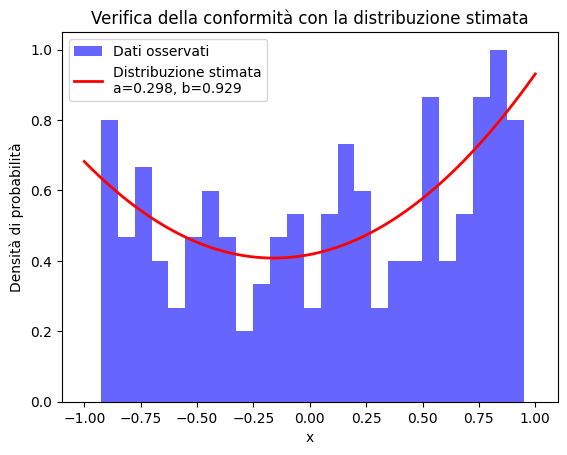

In [10]:
data = np.loadtxt("data_proj_one.dat")

a, b, errors, estimated_pdf = estimate_a_b(data)

print(f"Stima di a: {a:.3f} +/- {errors[0]:.3f}")
print(f"Stima di b: {b:.3f} +/- {errors[1]:.3f}")

# Generation of points for the estimated distribution
x_values = np.linspace(-1, 1, 500)
pdf_values = [estimated_pdf(x) for x in x_values]


# Plot comparison between histogram of data and the estimated curve
plt.hist(data, bins=25, density=True, alpha=0.6, color='blue', label='Dati osservati')
plt.plot(x_values, pdf_values, color='red', linewidth=2, label=f'Distribuzione stimata\na={a:.3f}, b={b:.3f}')
plt.title('Verifica della conformità con la distribuzione stimata')
plt.xlabel('x')
plt.ylabel('Densità di probabilità')
plt.legend()
plt.show()

In [5]:
# This function is used to get the
# the estimated pdf maximum.
def get_pdf_maximum(e_pdf):    
    return np.max([e_pdf(-1),e_pdf(1)])

# Function for random generation
# using the Monte Carlo method
def generate_random_monte_carlo(pdf, pdf_maximum, n_samples, x_min, x_max):
    samples = []
    while len(samples) < n_samples:
        sample = random.uniform(x_min,x_max)
        random_picker = random.uniform(0,pdf_maximum)
        if(pdf(sample) >= random_picker):
            samples.append(sample)
    return samples

In [6]:
import warnings


warnings.simplefilter("error", RuntimeWarning)
estimated_a = []
estimated_a_error = []
estimated_b = []
estimated_b_error = []

data_max = data.max()
data_min = data.min()

pdf_max = get_pdf_maximum(estimated_pdf)
d = False
# Making 500 simulations
for _ in range(1000):
    new_x = generate_random_monte_carlo(estimated_pdf, pdf_max, 500, data_min, data_max)

    new_a,new_b,errors,npdf = estimate_a_b(new_x)

    estimated_a.append(new_a)
    estimated_b.append(new_b)
    estimated_a_error.append(errors[0])
    estimated_b_error.append(errors[1])

KeyboardInterrupt: 

Text(0, 0.5, 'b')

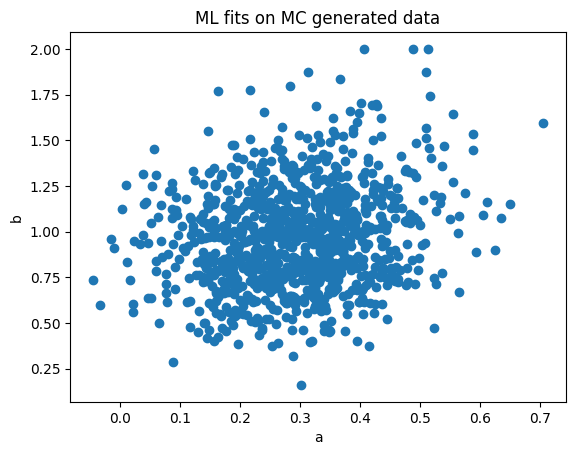

In [6]:
# Visualizations of data generated via Monte Carlo
plt.title('ML fits on MC generated data')    
plt.scatter(estimated_a,estimated_b,)
plt.xlabel('a')
plt.ylabel('b')

In [7]:
def plot_marginal_distribution(values, title, xlabel) : 
    plt.hist(values, bins=60, density=True, alpha=0.6, color='g')
    plt.title(title) 
    plt.xlabel(xlabel)

    mean = np.mean(values)
    error = np.std(values)

    x = np.linspace(mean - 4*error, mean + 4*error, 1000)
    pdf = norm.pdf(x, mean, error)

    plt.plot(x, pdf, 'r-', lw=2, label="Gaussian fit")
    plt.show()
    print(f"Estimated {xlabel}: {mean:.3f} +/- {error:.3f}")

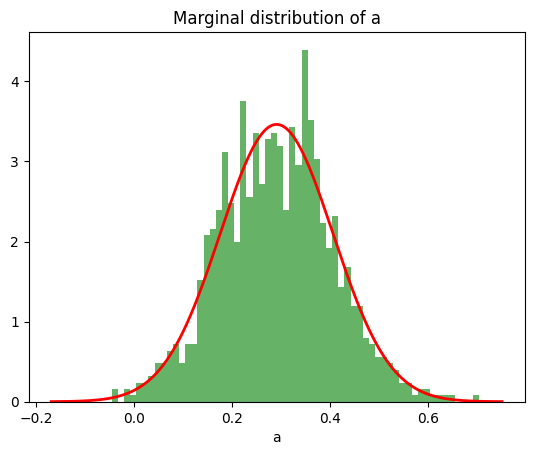

Estimated a: 0.291 +/- 0.115


In [8]:
plot_marginal_distribution(estimated_a, 'Marginal distribution of a', 'a')

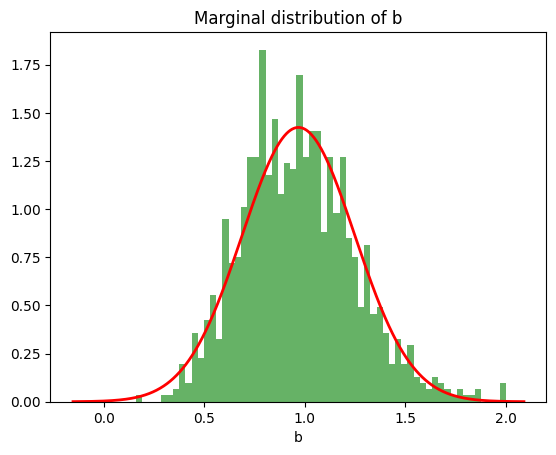

Estimated b: 0.968 +/- 0.280


In [9]:
plot_marginal_distribution(estimated_b, 'Marginal distribution of b', 'b')

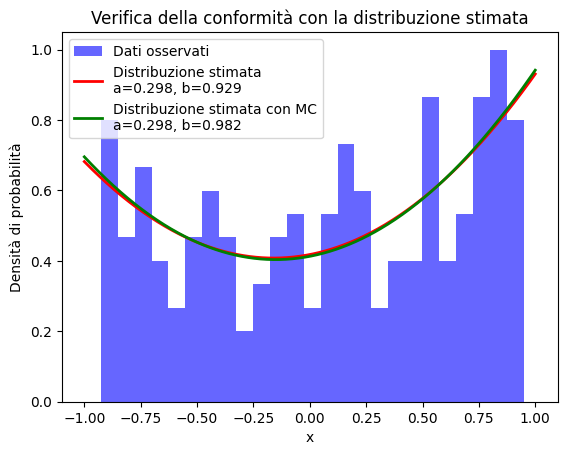

In [12]:
x_min = np.min(data)
x_max = np.max(data) 
# Generation of points for the estimated distribution
x_values = np.linspace(-1, 1, 500)
pdf_values = [estimated_pdf(x) for x in x_values]
mc_a = mean = np.mean(estimated_a)
mc_b = mean = np.mean(estimated_b)
pdf_values_mc = [pdf(x,mc_a,mc_b, x_max, x_min) for x in x_values]


# Plot comparison between histogram of data and the estimated curve
plt.hist(data, bins=25, density=True, alpha=0.6, color='blue', label='Dati osservati')
plt.plot(x_values, pdf_values, color='red', linewidth=2, label=f'Distribuzione stimata\na={a:.3f}, b={b:.3f}')
plt.plot(x_values, pdf_values_mc, color='green', linewidth=2, label=f'Distribuzione stimata con MC\na={mc_a:.3f}, b={mc_b:.3f}')
plt.title('Verifica della conformità con la distribuzione stimata')
plt.xlabel('x')
plt.ylabel('Densità di probabilità')
plt.legend()
plt.show()